In [1]:
from mmengine.config import Config
from mmocr.registry import DATASETS
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
from lmdb_dataset import CustomLMDBDataset # Import your custom dataset class

# Load config
cfg = Config.fromfile('../configs/etv_test1.py')
print(cfg.pretty_text)

default_hooks = dict(
    checkpoint=dict(_scope_='mmocr', interval=1, type='CheckpointHook'),
    logger=dict(_scope_='mmocr', interval=100, type='LoggerHook'),
    param_scheduler=dict(_scope_='mmocr', type='ParamSchedulerHook'),
    sampler_seed=dict(_scope_='mmocr', type='DistSamplerSeedHook'),
    sync_buffer=dict(_scope_='mmocr', type='SyncBuffersHook'),
    timer=dict(_scope_='mmocr', type='IterTimerHook'),
    visualization=dict(
        _scope_='mmocr',
        draw_gt=False,
        draw_pred=False,
        enable=False,
        interval=1,
        show=False,
        type='VisualizationHook'))
default_scope = 'mmocr'
dictionary = dict(
    dict_file=
    'd:/BIG Projects/Python/ETV/configs/../mmocr/dicts/english_digits_symbols.txt',
    same_start_end=True,
    type='Dictionary',
    with_end=True,
    with_padding=True,
    with_start=True,
    with_unknown=True)
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='f

In [2]:

# Build dataset
dataset = DATASETS.build(cfg.train_dataloader.dataset)

# Kiểm tra 1 sample đầu tiên
sample = dataset[0]
print(sample)


06/23 15:17:44 - mmengine - WARNING - test_dataset is not a meta file, simply parsed as meta information
06/23 15:17:44 - mmengine - WARNING - test_task is not a meta file, simply parsed as meta information
{'img_key': 'image-000000001', 'instances': [{'text': '<thead><tr><td>Câu lạc bộ</td><td>Tư cách vượt qua vòng loại</td><td>Ngày vượt qua vòng loại</td></tr></thead><tbody><tr><td>Becamex Bình Dương</td><td>Chủ nhà</td><td></td></tr><tr><td>Sông Lam Nghệ An</td><td>Nhất bảng A</td><td></td></tr><tr><td>Thừa Thiên Huế</td><td>Nhất bảng B</td><td></td></tr><tr><td>PVF</td><td>Nhất bảng C</td><td></td></tr><tr><td>Đồng Tháp</td><td>Nhất bảng D</td><td></td></tr><tr><td>Hoàng Anh Gia Lai</td><td>Nhì bảng C/Nhì bảng tốt nhất</td><td></td></tr><tr><td>An Giang</td><td>Nhì bảng D/Nhì bảng tốt thứ hai</td><td></td></tr><tr><td>Viettel</td><td>Nhì bảng A/Nhì bảng tốt thứ ba</td><td></td></tr></tbody>'}], 'sample_idx': 0, 'img': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 

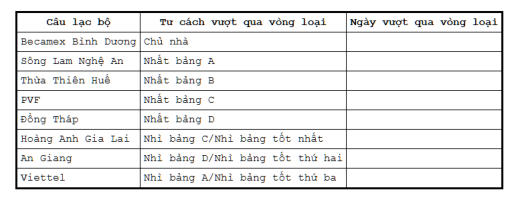

In [3]:
img, instances = sample['img'], sample['instances']
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')
plt.show()